# **Convolutional Neural Network**
**Starting parameters**:

- Number of epochs: 100
- Learning rate: 0.0005
- Layers: [64, 32, 32]
- Dropout: 0.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [25]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/CNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **CNN Model**

In [22]:
def build_model(audio_features,
                learning_rate=0.00005):

  tf.keras.backend.clear_session()

  # set audio features input layer
  inputs = tf.keras.layers.Input(shape=(audio_features.shape[1],audio_features.shape[2],audio_features.shape[3]), name='Audio_Features')


  features = tf.keras.layers.Conv2D(
              filters=64,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              data_format='channels_last',
              name='conv_1',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(inputs)

  features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1')(features)


  features = tf.keras.layers.Conv2D(
              filters=32,
              kernel_size=(5,5),
              strides=(1,1),
              padding='same',
              name='conv_2',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.15))(features)

  # features = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_2')(features)


  # features = tf.keras.layers.Conv2D(
  #             filters=32,
  #             kernel_size=(5,5),
  #             strides=(1,1),
  #             padding='same',
  #             name='conv_3',
  #             activation='relu',
  #             kernel_regularizer=tf.keras.regularizers.l2(0.15))(features)

  # features = tf.keras.layers.BatchNormalization()(features)
  features = tf.keras.layers.MaxPool2D(pool_size=(4,4), name='pool_3')(features)

  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=256,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=0.5)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities
  outputs = tf.keras.layers.Dense(
      units=20,
      name='fc_2',
      activation='softmax')(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[inputs],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

In [10]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_2D_annotated_2.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [12]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [13]:
train_results = {}
val_results = {}

val_scores = {}

### With All Features

In [14]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(train_features['cqt'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled, cqt_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 4)


In [15]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
cqt_tiled = tile_and_crop(val_features['cqt'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled, cqt_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 4)


In [23]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,257,396 (16.24 MB)

 Trainable params: 4,257,396 (16.24 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.1429 - loss: 11.1816 - weighted_accuracy: 0.1429 - val_accuracy: 0.3570 - val_loss: 8.0243 - val_weighted_accuracy: 0.3570
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.2627 - loss: 7.7141 - weighted_accuracy: 0.2627 - val_accuracy: 0.4348 - val_loss: 6.3830 - val_weighted_accuracy: 0.4348
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.3677 - loss: 6.1975 - weighted_accuracy: 0.3677 - val_accuracy: 0.5119 - val_loss: 5.2627 - val_weighted_accuracy: 0.5119
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.4646 - loss: 5.1140 - weighted_accuracy: 0.4646 - val_accuracy: 0.5170 - val_loss: 4.5023 - val_weighted_accuracy: 0.5170
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.5183 - loss: 4.3820 - weighted_accuracy: 0.5183 - val_accuracy: 0.6111 - val_loss: 4.0233 - val_weighted_accuracy: 0.6111
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s

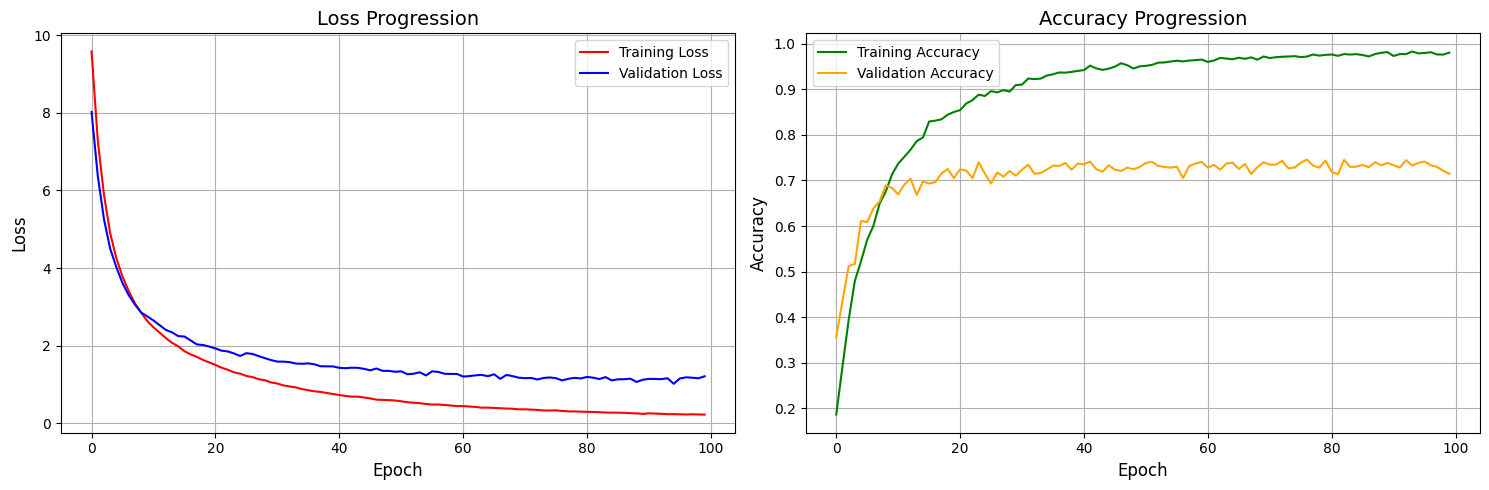

In [26]:
visualize(history, 'all_features')

In [27]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 1.0000 - loss: 0.1509 - weighted_accuracy: 1.0000
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7078 - loss: 1.2352 - weighted_accuracy: 0.7078


In [28]:
val_scores['all_features'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.75      0.74      0.74       114
           1       0.52      0.67      0.58       141
           2       0.81      0.85      0.83       271
           3       0.74      0.67      0.70        90
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        15
           6       0.23      0.65      0.34        23
           7       1.00      1.00      1.00        44
           8       0.54      0.58      0.56        50
           9       0.85      0.90      0.87        49
          10       0.76      0.58      0.66        48
          11       0.66      0.59      0.62        46
          12       0.95      1.00      0.97        54
          13       0.71      0.75      0.73        48
          14       0.63      0.76      0.69        38
          15       0.69      0.29      0.41       117
          16       1.00      0.95      0.97   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Mel Spectrogram and Chroma

In [29]:
# Train features
target_size = 128
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'],  chroma_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 2)


In [30]:
# Validation Features
target_size = 128
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'],  chroma_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 2)


In [31]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,254,196 (16.23 MB)

 Trainable params: 4,254,196 (16.23 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - accuracy: 0.1389 - loss: 9.0474 - weighted_accuracy: 0.1389 - val_accuracy: 0.3356 - val_loss: 6.7876 - val_weighted_accuracy: 0.3356
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.3219 - loss: 6.3834 - weighted_accuracy: 0.3219 - val_accuracy: 0.3948 - val_loss: 5.0005 - val_weighted_accuracy: 0.3948
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4279 - loss: 4.7288 - weighted_accuracy: 0.4279 - val_accuracy: 0.4681 - val_loss: 3.9097 - val_weighted_accuracy: 0.4681
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4856 - loss: 3.6784 - weighted_accuracy: 0.4856 - val_accuracy: 0.5548 - val_loss: 3.0980 - val_weighted_accuracy: 0.5548
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.5363 - loss: 3.0223 - weighted_accuracy: 0.5363 - val_accuracy: 0.5985 - val_loss: 2.6327 - val_weighted_accuracy: 0.5985
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 

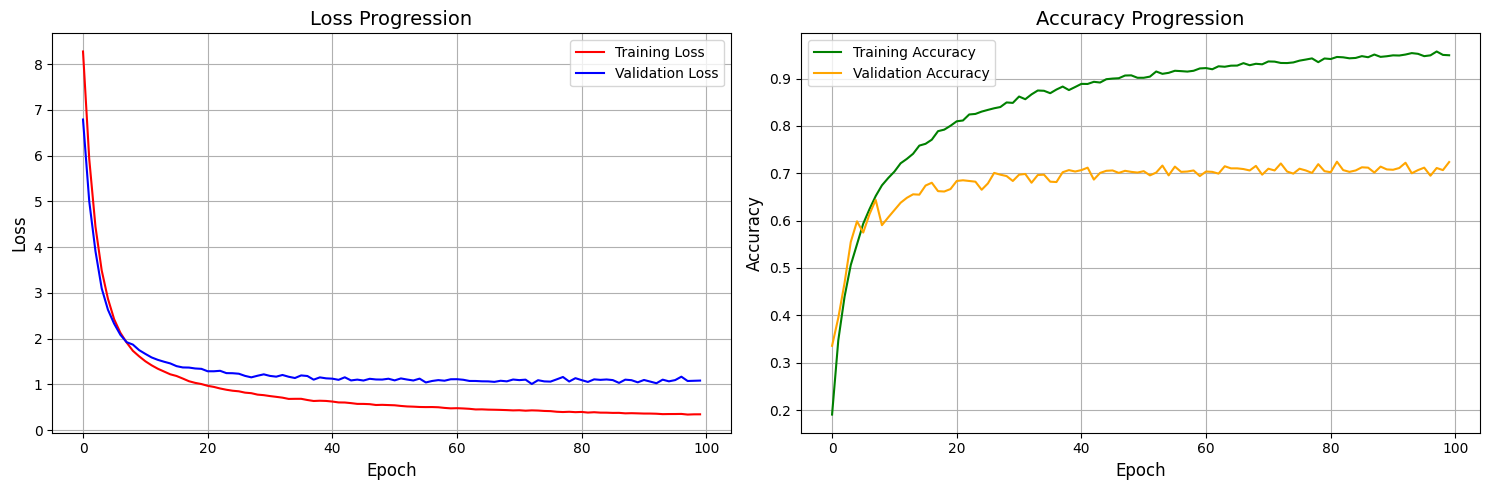

In [32]:
visualize(history, 'melspectrogram_chroma')

In [33]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9825 - loss: 0.2530 - weighted_accuracy: 0.9825
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7361 - loss: 1.0763 - weighted_accuracy: 0.7361


In [34]:
val_scores['melspectrogram_chroma'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       114
           1       0.45      0.60      0.51       141
           2       0.71      0.59      0.65       271
           3       0.80      1.00      0.89        90
           4       1.00      0.67      0.80        18
           5       0.73      0.53      0.62        15
           6       0.45      0.57      0.50        23
           7       0.96      0.98      0.97        44
           8       0.79      0.38      0.51        50
           9       0.98      0.94      0.96        49
          10       0.85      0.85      0.85        48
          11       0.73      0.65      0.69        46
          12       0.81      0.94      0.87        54
          13       0.47      0.71      0.56        48
          14       0.60      0.97      0.74        38
          15       0.71      0.46      0.56       117
          16       0.96      0.96      0.96   

### With Mel Spectrogram, MFCCs and Chroma

In [35]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(train_features['chroma'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 3)


In [36]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)
chroma_tiled = tile_and_crop(val_features['chroma'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled, chroma_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 3)


In [37]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,255,796 (16.23 MB)

 Trainable params: 4,255,796 (16.23 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.1577 - loss: 9.3155 - weighted_accuracy: 0.1577 - val_accuracy: 0.3926 - val_loss: 7.1305 - val_weighted_accuracy: 0.3926
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.3401 - loss: 6.7376 - weighted_accuracy: 0.3401 - val_accuracy: 0.4415 - val_loss: 5.3981 - val_weighted_accuracy: 0.4415
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.4157 - loss: 5.1944 - weighted_accuracy: 0.4157 - val_accuracy: 0.4852 - val_loss: 4.3118 - val_weighted_accuracy: 0.4852
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.4949 - loss: 4.1194 - weighted_accuracy: 0.4949 - val_accuracy: 0.4970 - val_loss: 3.6157 - val_weighted_accuracy: 0.4970
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5441 - loss: 3.4196 - weighted_accuracy: 0.5441 - val_accuracy: 0.5311 - val_loss: 3.0512 - val_weighted_accuracy: 0.5311
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 

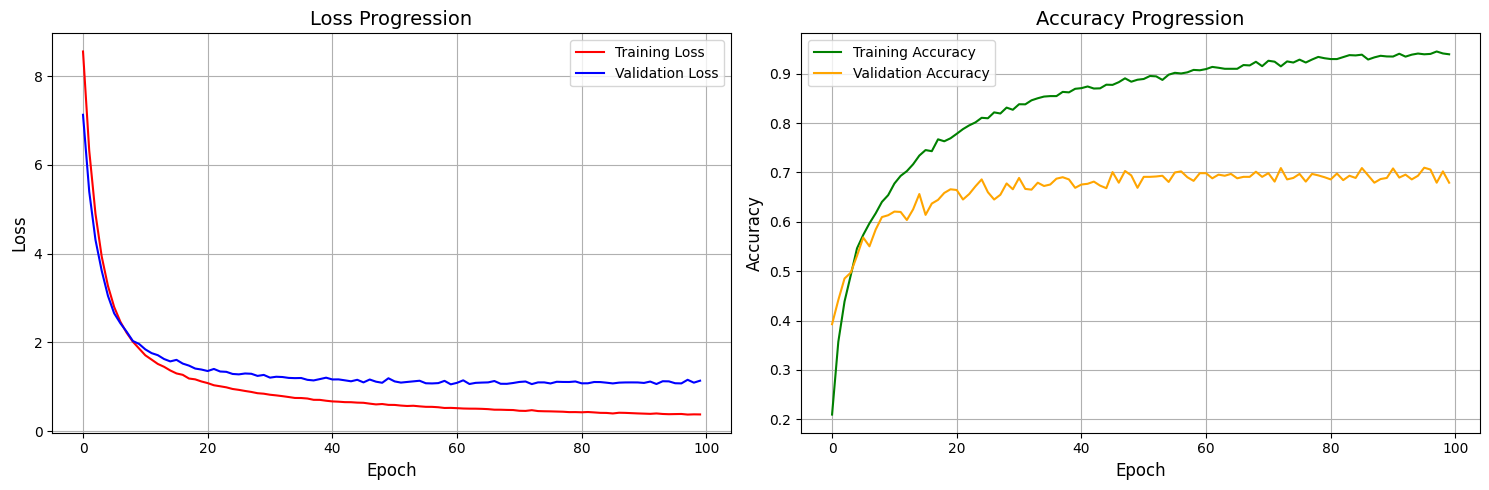

In [38]:
visualize(history, 'melspectrogram_chroma_mfcc')

In [39]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9786 - loss: 0.2788 - weighted_accuracy: 0.9786
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6819 - loss: 1.1469 - weighted_accuracy: 0.6819


In [40]:
val_scores['melspectrogram_chroma_mfcc'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       114
           1       0.36      0.51      0.42       141
           2       0.66      0.54      0.59       271
           3       0.80      1.00      0.89        90
           4       0.75      0.33      0.46        18
           5       0.56      0.33      0.42        15
           6       0.33      0.48      0.39        23
           7       1.00      0.98      0.99        44
           8       0.61      0.40      0.48        50
           9       0.77      0.98      0.86        49
          10       0.86      0.77      0.81        48
          11       0.68      0.54      0.60        46
          12       0.90      0.83      0.87        54
          13       0.44      0.65      0.52        48
          14       0.62      0.89      0.73        38
          15       0.80      0.37      0.50       117
          16       0.92      1.00      0.96   

### With Mel Spectrogram and MFCCs

In [41]:
# Train features
target_size = 128
mfcc_tiled = tile_and_crop(train_features['mfcc'], target_size)

training_features = np.stack((train_features['melspectrogram'], mfcc_tiled), axis=-1)
print(training_features.shape)

(5278, 128, 259, 2)


In [42]:
# Validation Features
target_size = 128
mfcc_tiled = tile_and_crop(val_features['mfcc'], target_size)

validation_features = np.stack((val_features['melspectrogram'], mfcc_tiled), axis=-1)
print(validation_features.shape)

(1350, 128, 259, 2)


In [43]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,254,196 (16.23 MB)

 Trainable params: 4,254,196 (16.23 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.1321 - loss: 9.0991 - weighted_accuracy: 0.1321 - val_accuracy: 0.3185 - val_loss: 6.9939 - val_weighted_accuracy: 0.3185
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.2708 - loss: 6.5621 - weighted_accuracy: 0.2708 - val_accuracy: 0.4074 - val_loss: 5.3519 - val_weighted_accuracy: 0.4074
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.3128 - loss: 5.0826 - weighted_accuracy: 0.3128 - val_accuracy: 0.3896 - val_loss: 4.2766 - val_weighted_accuracy: 0.3896
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3465 - loss: 4.1294 - weighted_accuracy: 0.3465 - val_accuracy: 0.4259 - val_loss: 3.5316 - val_weighted_accuracy: 0.4259
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.3998 - loss: 3.4577 - weighted_accuracy: 0.3998 - val_accuracy: 0.3748 - val_loss: 3.0604 - val_weighted_accuracy: 0.3748
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 

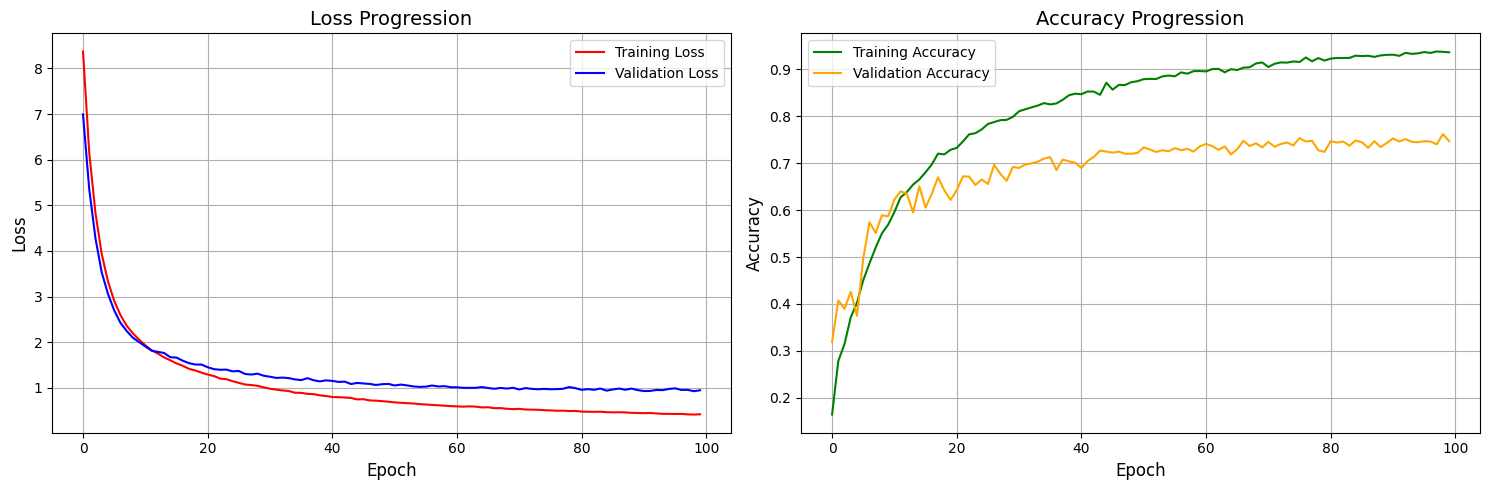

In [44]:
visualize(history, 'mfcc_melspectrogram')

In [45]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9732 - loss: 0.3152 - weighted_accuracy: 0.9732
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7516 - loss: 0.9507 - weighted_accuracy: 0.7516


In [46]:
val_scores['mfcc_melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.79      0.76      0.78       114
           1       0.74      0.48      0.58       141
           2       0.79      0.87      0.83       271
           3       0.90      1.00      0.95        90
           4       1.00      0.06      0.11        18
           5       0.00      0.00      0.00        15
           6       0.27      0.43      0.33        23
           7       1.00      1.00      1.00        44
           8       0.50      0.68      0.58        50
           9       0.88      0.94      0.91        49
          10       0.82      0.67      0.74        48
          11       0.73      0.35      0.47        46
          12       0.78      0.78      0.78        54
          13       0.70      0.90      0.79        48
          14       0.58      0.76      0.66        38
          15       0.56      0.59      0.57       117
          16       0.83      0.98      0.90   

### With Mel Spectrogram

In [47]:
# Train features
target_size = 128

training_features = np.expand_dims(train_features['melspectrogram'], axis=-1)
print(training_features.shape)

(5278, 128, 259, 1)


In [48]:
# Validation Features
target_size = 128
validation_features = np.expand_dims(val_features['melspectrogram'], axis=-1)
print(validation_features.shape)

(1350, 128, 259, 1)


In [49]:
model = build_model(training_features)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=1
)

Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Audio_Features (InputLayer)          │ (None, 128, 259, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 128, 259, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 64, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 64, 129, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 16, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,252,596 (16.22 MB)

 Trainable params: 4,252,596 (16.22 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.1255 - loss: 8.8382 - weighted_accuracy: 0.1255 - val_accuracy: 0.2267 - val_loss: 6.8238 - val_weighted_accuracy: 0.2267
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.1834 - loss: 6.4208 - weighted_accuracy: 0.1834 - val_accuracy: 0.2815 - val_loss: 5.1240 - val_weighted_accuracy: 0.2815
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.2744 - loss: 4.9002 - weighted_accuracy: 0.2744 - val_accuracy: 0.3896 - val_loss: 4.0070 - val_weighted_accuracy: 0.3896
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3371 - loss: 3.9229 - weighted_accuracy: 0.3371 - val_accuracy: 0.4985 - val_loss: 3.3107 - val_weighted_accuracy: 0.4985
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3908 - loss: 3.2725 - weighted_accuracy: 0.3908 - val_accuracy: 0.5467 - val_loss: 2.8139 - val_weighted_accuracy: 0.5467
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 

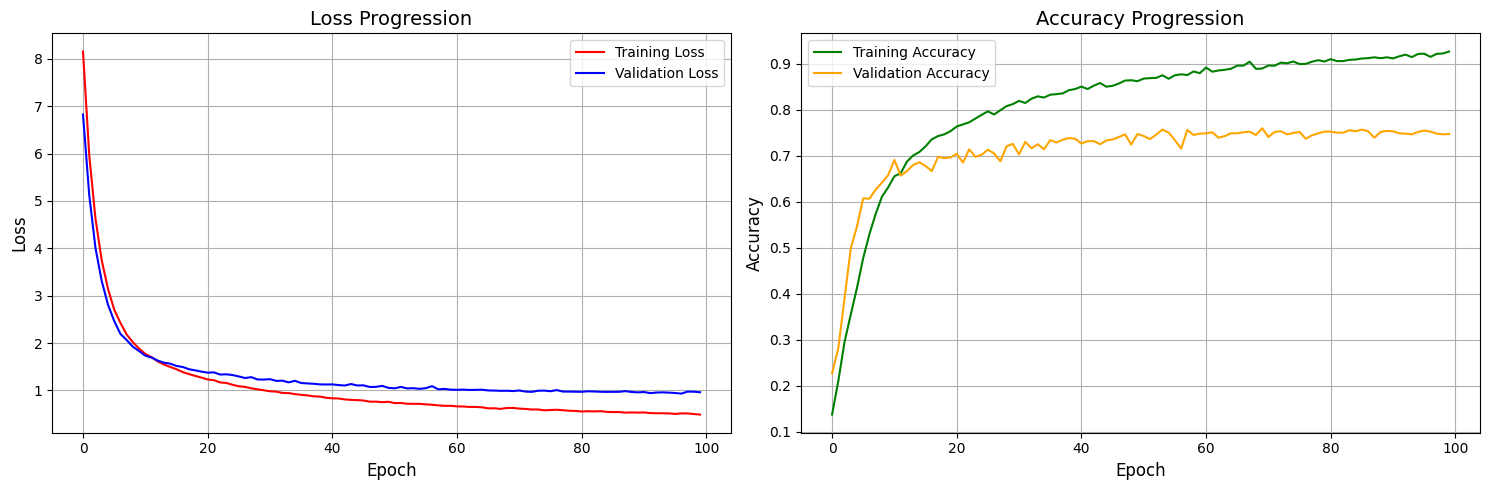

In [50]:
visualize(history, 'melspectrogram')

In [51]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9731 - loss: 0.3612 - weighted_accuracy: 0.9731
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7388 - loss: 0.9837 - weighted_accuracy: 0.7388


In [52]:
val_scores['melspectrogram'] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

Validation classification Report 

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       114
           1       0.56      0.60      0.58       141
           2       0.81      0.76      0.79       271
           3       0.84      1.00      0.91        90
           4       1.00      0.06      0.11        18
           5       0.00      0.00      0.00        15
           6       0.29      0.30      0.30        23
           7       0.98      1.00      0.99        44
           8       0.75      0.66      0.70        50
           9       0.96      0.92      0.94        49
          10       0.75      0.79      0.77        48
          11       0.75      0.52      0.62        46
          12       0.71      0.96      0.82        54
          13       0.62      0.92      0.74        48
          14       0.72      0.76      0.74        38
          15       0.58      0.56      0.57       117
          16       0.86      0.98      0.92   

## Review all the results

In [53]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,1.000,0.715
4,melspectrogram,0.971,0.747
1,melspectrogram_chroma,0.982,0.724
2,melspectrogram_chroma_mfcc,0.977,0.679
3,mfcc_melspectrogram,0.972,0.747


In [54]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)

                     Features  F1_Score  AUC_Score
0                all_features     0.706      0.971
4              melspectrogram     0.738      0.975
1       melspectrogram_chroma     0.722      0.966
2  melspectrogram_chroma_mfcc     0.676      0.963
3         mfcc_melspectrogram     0.735      0.974
